In [ ]:
# !python -m venv venv
# # !venv/scripts/activate
%pip install pandas numpy matplotlib seaborn plotly geopandas scipy scikit-learn statsmodels requests aiohttp shapely ipython h3 ipywidgets dtale tqdm pickle

In [1]:

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

import requests
import os

import datetime as dt
import time

from pandas import read_csv
import concurrent.futures
import psutil

from datetime import datetime

import h3
import geopandas as gpd
import shapely
import plotly.express as px

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
from pandas import read_pickle

from enum import Enum


In [ ]:
# Verify that the hexagon grid is suitable
# create_choropleth_map_only_hexagon_df(geojson_df=hexagon_df)

# def create_choropleth_map_only_hexagon_df(geojson_df, alpha=0.1, map_style="carto-positron", color_scale="Viridis"):
#     """
#     Create an interactive choropleth map using Plotly Express.
#     Parameters:
#     - geojson_df (GeoDataFrame): GeoJSON data containing polygon geometries.
#     - alpha (float): Opacity level for the map polygons (0.0 to 1.0).
#     - map_style (str): Map style for the Plotly map (e.g., "carto-positron").
#     - color_scale (str): Color scale for the choropleth map.
#     Returns:
#     None
#     """
#     # Create a choropleth map using px.choropleth_mapbox
#     fig = px.choropleth_mapbox(
#         geojson_df,
#         geojson=geojson_df.geometry,
#         locations=geojson_df.index,  # Use index as locations to avoid duplicate rows
#         # color="Count",
#         color_continuous_scale=color_scale,
#         title="GPS Jam Map",
#         mapbox_style=map_style,
#         center={"lat": home_lat, "lon": home_lng},  # Adjust the center as needed
#         zoom=2,
#     )

#     # Customize the opacity of the hexagons
#     fig.update_traces(marker=dict(opacity=alpha))

#     # Set margins to 25 on all sides
#     fig.update_layout(margin=dict(l=35, r=35, t=45, b=35))
    
#     # Adjust the width of the visualization
#     fig.update_layout(width=1000) 

#     fig.show()


In [ ]:



# Latitude and longitude coordinates
home_lat = 1.3472764
home_lng = 103.9104234

# Generate H3 hexagons at a specified resolution (e.g., 9)
resolution = 5

# Indicate the number of rings around the central hexagon
ring_size = 463



def calculate_hexagon_ids(df):
    """
    Calculate Hexagon IDs for each row(ping) in a DataFrame based on their geographic coordinates.
    Args:
        df (pd.DataFrame): DataFrame containing ADSB data with "lat" and "lon" columns.
        hexagon_df (gpd.GeoDataFrame): GeoDataFrame with hexagon geometries and associated Hexagon IDs.
    Returns:
        pd.DataFrame: The input DataFrame with an additional "Hexagon_ID" column indicating the Hexagon ID for each ping.
    """

    # Create a column Hexagon_ID with the ID of the hexagon
    df['Hexagon_ID'] = None

    # Iterate through the hotels in the df DataFrame and calculate hotel counts within each hexagon
    for i, ping in df.iterrows():
        if not isinstance(ping['lat'], float):
            continue  
        resolution=5   
        result = h3.geo_to_h3(ping["lat"], ping["lon"], resolution)
        # print(f'{ping["lat"]},{ping["lon"]}=>{result}')
        if result != 0:
             df.loc[i, 'Hexagon_ID'] = result
    
    return df

def time_elapsed(start_time):
    end_time = time.time()
    return end_time - start_time

time_data={
    "pickle": 0,
    "url": 0,
    "concat": 0,
}

def get_adsb_data(data):
    response = requests.get(data["url"])
    print(f"downloaded {data['url']}")
    json_data = response.json()
    
    df = pd.json_normalize(json_data['aircraft'])
    df = df.fillna("Nan values")
    df = df[df["type"] == 'adsb_icao']
    df['time'] = datetime.fromtimestamp(json_data['now']).strftime("%Y%m%d%H%M%S")
    df['good_bad'] = df['nic'].apply(lambda x: 'bad' if x=="Nan values" or int(x)<=6 else 'good')
    df['alt_baro'] = df['alt_baro'].apply(lambda x: 0 if (x == "ground" or x == "Nan values" ) else float(x))
    df["nic"] = df['nic'].apply(lambda x: int(float(x)) if x !="Nan values" else 0)


    df['Hexagon_ID'] = None
    df = df[['Hexagon_ID', 'r', 'time', 'alt_baro', 'nic', 'good_bad', 'hex','lat','lon','type','flight','t','category','version','nac_p','nac_v']]
    df = df.map(lambda x: ', '.join(x) if isinstance(x, list) else x)
    df = df[df["r"]!="Nan values"]

    df = calculate_hexagon_ids(df)

    #save to pickle
    if not os.path.exists(os.path.dirname(data["csv"])):
        os.makedirs(os.path.dirname(data["csv"]))
    df.to_csv(data["csv"])
    return df

def download_data(index, data, length_data_array, start_time_overall):
    start_time = time.time()

    try:
        # if pickle exists, do nothing
        if (os.path.isfile(data["csv"])):
            print(f"csv exists {data['csv']}")
            return
        else:
            get_adsb_data(data)

            time_data["url"] += time_elapsed(start_time)

            remaining_time = (time.time() - start_time_overall)/(index+1) * (length_data_array - index)
            print(f"Remaining execution time: {remaining_time//60:.0f}m {remaining_time%60:.0f}s")

            return

    except Exception as e:
        # Handle other exceptions
        print("An error occurred:", e)

def join_large_csv(folder_path,start,end,file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
    isHeader = True
    with open(file_path, 'w') as outfile:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            file_datetime = datetime.strptime(file_path, 'csv\\%Y%m%d\\%H%M%SZ.csv')
            print(file_datetime)
            # csv_path = os.path.join('csv',start.strftime("%Y%m%d"), f'{start.strftime("%H%M%S")}Z.csv')
            if filename.endswith('.csv') and start <= file_datetime and file_datetime <= end:
                with open(file_path, 'r') as infile:
                    # skip row header
                    if isHeader:
                        outfile.write(infile.read())
                        isHeader = False
                    else:
                        outfile.write(''.join(infile.readlines()[1:]))
                print(f'Joined {file_path}')

def sampling(datestring, file_path, reload=False):
    sampled_file_path = os.path.join('csv','joined', f'{datestring}sampled.csv')
    bad_path = os.path.join('csv','joined', f'{datestring}bad.csv')
    good_path = os.path.join('csv','joined', f'{datestring}good.csv')

    df1 = read_csv(file_path)
    df1_sampled = df1.groupby('good_bad').apply(
        lambda x: x.sample(frac=0.20)
    )
    
    df1_sampled = df1_sampled.sort_values(by=["r","time","Hexagon_ID"], ascending=[True,True,True])
    df1_sampled.to_csv(sampled_file_path)
    print("sampled csv complete")

def load_data(start_date_time,end_date_time, reload=[False,False,False]):
    delta = dt.timedelta(seconds=5)
    start = start_date_time
    df1 = None
    df2 = None
    csv_path = os.path.join('csv', 'joined', f'{start_date_time.strftime("%Y%m%d")}joined.csv')
    hexbin_path = os.path.join('csv', 'hexbin', f'{start_date_time.strftime("%Y%m%d")}hexbin.csv')
    sampled_path = os.path.join('csv', 'joined', f'{start_date_time.strftime("%Y%m%d")}sampled.csv')

    if not reload[0]:

        data_array = []
        while start < end_date_time:
            data_array.append({
                "url": f'https://samples.adsbexchange.com/readsb-hist/{start.strftime("%Y/%m/%d")}/{start.strftime("%H%M%S")}Z.json.gz',
                "pickle": os.path.join('pickle',start.strftime("%Y%m%d"), f'{start.strftime("%H%M%S")}Z.pkl'),
                "csv": os.path.join('csv',start.strftime("%Y%m%d"), f'{start.strftime("%H%M%S")}Z.csv')
                })
            start += delta

        report1=""
        report2=""

        start_time_overall = time.time()

        with concurrent.futures.ThreadPoolExecutor() as executor:
            l = [len(data_array)] * len(data_array)
            list(executor.map(lambda i: download_data(i, data_array[i], l[i], start_time_overall), range(len(data_array))))
            report1 = get_memory_usage()

        join_large_csv(os.path.join('csv',start_date_time.strftime("%Y%m%d")),start_date_time,end_date_time,csv_path)

        start_time_overall = time.time()
        print(f"Download memory usage\n{report1}\n\n")
        print(f"CSV memory usage\n{report2}")
        # only when all the threads are complete, then concat happens
        print(f'Total directory size: {get_directory_size("csv"):.1f} MB')
        print(f"Download time: {(time_data['url']/3600):.1f} min")
        print(f"CSV time: {(time_data['pickle']/3600):.1f} min")
    
    if not reload[1]:
        print("sampling: partially from the 'good' rows and all of the 'bad' rows")
        sampling(start_date_time.strftime("%Y%m%d"), csv_path)
        print("sampling done")

    print("loading csv")
    # df1 = read_csv(sampled_path)
    df1 = pd.concat([chunk for chunk in tqdm(pd.read_csv(sampled_path, chunksize=10000), desc='Loading data')])
    print("csv loaded")

    return [df1, None]

    if not reload[2]:

        df2 = groupby_hexagon_ID(df1, hexbin_path)
    
    else:
        # df2 = read_csv(hexbin_path)
        df2 = pd.concat([chunk for chunk in tqdm(pd.read_csv(hexbin_path, chunksize=10000), desc='Loading hexbin')])

    return [df1, df2]

def groupby_hexagon_ID(df1, hexbin_path):
    df2 = df1.groupby(['Hexagon_ID', 'r'], as_index=False).agg(
                            good_count=('good_bad', lambda x: (x == 'good').sum()),
                            bad_count=('good_bad', lambda x: (x == 'bad').sum()),
                            alt_baro_range=('alt_baro', lambda x: (x.max() - x.min())),
                            time_range=('time', lambda x: x.max() - x.min()))

    df2["total_count"]=df2["good_count"]+df2["bad_count"]
    df2["percentage_bad"]=df2["bad_count"]/df2["total_count"]
    def get_lat(row):
        return h3.h3_to_geo(row['Hexagon_ID'])[0]

    def get_lng(row):
        return h3.h3_to_geo(row['Hexagon_ID'])[1]

    # Apply the function to create new 'lat' and 'lng' columns
    df2['lat'] = df2.apply(get_lat, axis=1)
    df2['lng'] = df2.apply(get_lng, axis=1)

    unique = df1.groupby('Hexagon_ID', as_index=False)['r'].nunique().sort_values('r',ascending=False)
    unique = unique.rename(columns={"r": "r_count"})

    df2 = df2.merge(unique, on='Hexagon_ID', how='left').sort_values(["r_count", "Hexagon_ID"], ascending=[False,True])
    df2 = df2[['Hexagon_ID', 'r_count',	'r', 'good_count','bad_count','alt_baro_range','time_range','total_count','percentage_bad']]
    df2 = df2.groupby('Hexagon_ID')[['r_count','r', 'good_count','bad_count','alt_baro_range','time_range','total_count','percentage_bad']]
    df2.sum().reset_index().to_csv(hexbin_path)

    return df2

def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
            total_size_mb = total_size / (1024 * 1024)
    return total_size_mb

def get_memory_usage():

    # Get the memory usage
    memory_usage = psutil.virtual_memory()

    # Print the memory usage
    report = f"""
        Total Memory: {memory_usage.total / (1024 ** 3):.2f} GB
        Available Memory: {memory_usage.available / (1024 ** 3):.2f} GB
        Used Memory: {memory_usage.used / (1024 ** 3):.2f} GB
        Memory Usage Percentage: {memory_usage.percent:.2f}%
    """
    return report

# note that for the free sample, only the first day of each month is available on the adsbexchange
# 4 hours + to download 1 day of files
# 18 mins to reload

# Reload flags are for skipping steps and saving processing time
# reload[0] - 'False' downloads csv files if not exist and then joins the csv files into {date}joined.csv
#           - 'True' just uses the existing {date}joined.csv file
# reload[1] - 'False' samples the bad and good rows from {date}joined.csv file and saves as {date}sampled.csv
#           - 'True' just uses the existing {date}sampled.csv file
# reload[2] - 'False' runs grouby aggregate and sorts by Hexagon ID and saves as {date}hexbin.csv file
#           - 'True' just uses the existing {date}hexbin.csv file

[df1,df2] = load_data(dt.datetime(2024,6,1,0,0,0),dt.datetime(2024,6,2,0,0,0), reload=[True, False, False])



In [ ]:
df1.head(200)

In [2]:
start_date_time = dt.datetime(2024,6,1,0,0,0)
csv_path = os.path.join('csv', 'joined', f'{start_date_time.strftime("%Y%m%d")}joined.csv')
joined_pickle_path = os.path.join('csv', 'joined', f'{start_date_time.strftime("%Y%m%d")}joined.pkl')

fileType = {
    "JOINED": "joined",
    "BAD": "bad",
    "GOOD": "good",
    "SAMPLED": "sampled",
    "EQUIPMENT_FAILURE": "eqpt_failure",
    "NORMAL": "normal",
    "UNKNOWN": "unknown",
    "HEXBIN": "hexbin",
}

def save_df(df, start_date_time, filetype=fileType.JOINED, pickle=True, csv=True):
    directory = 'joined'
    if filetype == fileType.HEXBIN:
        directory = 'hexbin'
    if pickle:
        file_path = os.path.join('csv', directory , f'{start_date_time.strftime("%Y%m%d")}{filetype}.pkl')
        print(f'Saving pickle {file_path}')
        df.to_pickle(file_path) 
    if csv:
        file_path = os.path.join('csv', directory , f'{start_date_time.strftime("%Y%m%d")}{filetype}.csv')
        print(f'Saving csv {file_path}')
        df.to_csv(file_path) 

def load_df(start_date_time, filetype=fileType.JOINED, pickle=True, csv=True):
    directory = 'joined'
    df1=None
    df2=None
    if filetype == fileType.HEXBIN:
        directory = 'hexbin'
    if pickle:
        file_path = os.path.join('csv', directory , f'{start_date_time.strftime("%Y%m%d")}{filetype}.pkl')
        print(f'Reading pickle {file_path}')
        df1 = read_pickle(file_path) 
    if csv:
        file_path = os.path.join('csv', directory , f'{start_date_time.strftime("%Y%m%d")}{filetype}.csv')
        df2 = pd.concat([chunk for chunk in tqdm(pd.read_csv(file_path, chunksize=1000000), desc=f'Loading csv {file_path}')])
    return [df1,df2]

In [5]:

# 6 mins loading
df1 = pd.concat([chunk for chunk in tqdm(pd.read_csv(csv_path, chunksize=1000000), desc='Loading data')])

df1.to_pickle(joined_pickle_path)

Loading data: 158it [04:11,  1.59s/it]


In [3]:
df1 = read_pickle(joined_pickle_path)

In [4]:
df1.head(10)
print(df1.shape)

(10000000, 17)


In [94]:
flight_rows = []
flights = None
for r, rows in df1.groupby("r"):
    flight_rows.append(rows)
    flights = pd.concat([flights,pd.DataFrame({'flight': [r],'row_count': [len(rows)], 'bad_count': [rows[rows['nic']<7].shape[0]]})])
    # rows['consecutive']
flights.drop(0)
flights.set_index('flight', inplace=True)
flights['consecutive']=0
for r, rows in df1.groupby("r"):
    counter = 0
    max_counter=0
    if flights.at[r,'bad_count']>0:
        for index, row in rows.iterrows():
            if row['nic']<7:
                counter+=1
                if counter>max_counter:
                    max_counter=counter
            else:
                counter=0
        flights.at[r,'consecutive']=max_counter
    flights.at[r,'percentage_bad']=flights.at[r,'bad_count']/flights.at[r,'row_count']

    if flights.at[r,'consecutive']>0.5*flights.at[r,'row_count'] or flights.at[r,'bad_count']>0.5*flights.at[r,'row_count']:
        flights.at[r,'result']='equipment failure'
    elif flights.at[r,'bad_count']<0.1*flights.at[r,'row_count']:
        flights.at[r,'result']='normal'
    else:
        flights.at[r,'result']='unknown'

flights = flights.sort_values('consecutive', ascending=False)
print(flights.head(10))


          row_count  bad_count  consecutive  percentage_bad             result
flight                                                                        
EC-NBO         1125       1125         1125        1.000000  equipment failure
TC-LCS         1124       1124         1124        1.000000  equipment failure
SE-RSF         1110       1110         1110        1.000000  equipment failure
9M-MAD          883        883          883        1.000000  equipment failure
N700CK          879        879          879        1.000000  equipment failure
23-8855         870        870          870        1.000000  equipment failure
B-18775        1125       1123          864        0.998222  equipment failure
A6-EPC          849        849          849        1.000000  equipment failure
RA-73067        830        830          830        1.000000  equipment failure
SE-RNE          855        849          826        0.992982  equipment failure


In [96]:
flights_equipment_failure = flights[flights['result']=='equipment failure']
print(flights_equipment_failure.shape[0])

flights_normal = flights[flights['result']=='normal']
print(flights_normal.shape[0])

flights_unknown = flights[flights['result']=='unknown']
print(flights_unknown.shape[0])
print(flights_unknown.sample(50))



368
17214
1071
          row_count  bad_count  consecutive  percentage_bad   result
flight                                                              
N804HM           62         13            7        0.209677  unknown
A6-EFI          478         70           15        0.146444  unknown
B-6832          107         21            9        0.196262  unknown
PH-HXN           76          8            2        0.105263  unknown
EW-456PA        515        117           72        0.227184  unknown
N226NG           10          2            2        0.200000  unknown
B-1072          162         53           52        0.327160  unknown
HL8363          199         30           21        0.150754  unknown
B-7667          317         98           42        0.309148  unknown
N3873Q           28         13           13        0.464286  unknown
B-5781           75         24           15        0.320000  unknown
N743AM          167         28           11        0.167665  unknown
N733JA          156

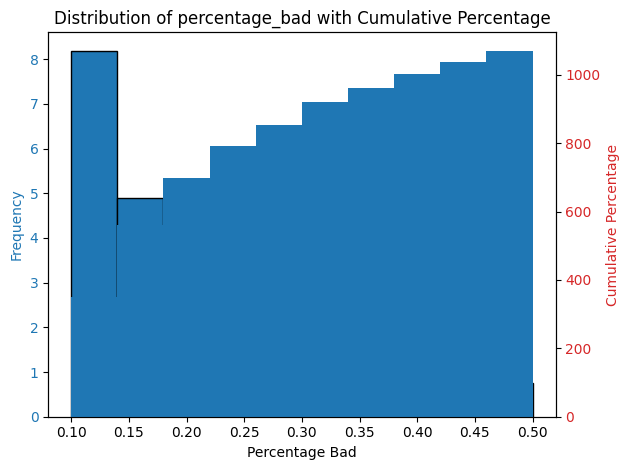

In [107]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.hist(flights_unknown['percentage_bad'], bins=10, edgecolor='black', cumulative=False, density=True, color=color)
ax1.set_xlabel('Percentage Bad')
ax1.set_ylabel('Frequency', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
flights_unknown['percentage_bad'].plot(kind='hist', bins=10, cumulative=True, density=False, color=color, ax=ax2)
ax2.set_ylabel('Cumulative Percentage', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Distribution of percentage_bad with Cumulative Percentage')
fig.tight_layout()
plt.show()

In [21]:
def divide_chunks(l, n): 
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n]

x = list(divide_chunks(flights, 100)) 
print (len(x[1])) 

100


In [ ]:

# split the original csv into good and bad. For the bad load all lines. For the good load only samples

# datestring = "20240601"
# df1 = read_csv(os.path.join('csv','joined', f'{datestring}joined.csv'))
# df1["nic"] = df1['nic'].apply(lambda x: int(float(x)) if x !="Nan values" else 0)
# df1['good_bad'] = df1['nic'].apply(lambda x: 'bad' if x=="Nan values" or int(x)<=6 else 'good')
# df1['alt_baro'] = df1['alt_baro'].apply(lambda x: 0 if (x == "ground" or x == "Nan values" ) else int(x))

# df1=df1[['Hexagon_ID', 'r', 'time', 'alt_baro', 'nic', 'good_bad', 'hex','lat','lon','type','flight','t','category','version','nac_p','nac_v']]
# df1 = df1.sort_values(by=["Hexagon_ID","r","time"], ascending=[True,True,True])

# df1_bad = df1[df1['good_bad']=='bad']
# df1_bad.to_csv(os.path.join('csv','joined', f'{datestring}bad.csv'))

# df1_good = df1[df1['good_bad']=='good']
# df1_good.to_csv(os.path.join('csv','joined', f'{datestring}good.csv'))

# print(df1_bad.head(10))
# print(df1_good.head(10))

# # %%
# file_path = os.path.join('csv','joined', f'{datestring}joined-2.csv')
# bad_path = os.path.join('csv','joined', f'{datestring}bad.csv')
# good_path = os.path.join('csv','joined', f'{datestring}good.csv')
# with open(file_path, 'w') as outfile:
#     with open(bad_path, 'r') as infile:
#         outfile.write(infile.read())
#         isHeader = False
#     with open(good_path, 'r') as infile:
#         lines = infile.readlines()
#         filtered_lines = [line for i, line in enumerate(lines[1:]) if (i + 1) % 10 != 0]
#         outfile.write(''.join(filtered_lines))
#     print(f'Joined {file_path}')
# df1 = read_csv(os.path.join('csv','joined', f'{datestring}joined-2.csv'))
# df1 = df1[df1["r"]!="Nan values"]

# df1 = df1.sort_values(by=["Hexagon_ID","r","time"], ascending=[True,True,True])
# df1.to_csv(os.path.join('csv','joined', f'{datestring}joined-2.csv'))



In [ ]:
# df2 = df1.groupby(['Hexagon_ID', 'r'], as_index=False).agg(
#     good_count=('good_bad', lambda x: (x == 'good').sum()),
#     bad_count=('good_bad', lambda x: (x == 'bad').sum()),
#     alt_baro_range=('alt_baro', lambda x: (x.max() - x.min())),
#     time_range=('time', lambda x: x.max() - x.min()))
# df2["total_count"]=df2["good_count"]+df2["bad_count"]
# df2["percentage_bad"]=df2["bad_count"]/df2["total_count"]
# unique = df1.groupby('Hexagon_ID', as_index=False)['r'].nunique().sort_values('r',ascending=False)
# unique = unique.rename(columns={"r": "r_count"})

# print(unique.head(10))

# df2 = df2.merge(unique, on='Hexagon_ID', how='left').sort_values(["r_count", "Hexagon_ID"], ascending=[False,True])
# df2 = df2[['Hexagon_ID', 'r_count',	'r', 'good_count','bad_count','alt_baro_range','time_range','total_count','percentage_bad']]
# df2.to_csv(os.path.join('csv','hexbin', f'{datestring}hexbin.csv'))

# df3 = df2.groupby('Hexagon_ID')[['r_count','r', 'good_count','bad_count','alt_baro_range','time_range','total_count','percentage_bad']]

# df3.head(10)


In [ ]:
# select these rows because it has the highest confidence
# df2_select = df2.query('bad_count>0 and total_count>20 and percentage_bad<1')
# print(f"{df2_select.shape[0]} of {df2.shape[0]}")
# df2_select = df2_select.sort_values(["bad_count"], ascending=[False])

# df2_select.head(10)



In [ ]:

# https://towardsdatascience.com/3-python-packages-for-interactive-data-analysis-3063a201a589
# https://towardsdatascience.com/4-libraries-that-can-perform-eda-in-one-line-of-python-code-b13938a06ae


In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df1['time'], df1['alt_baro'], 'b-', label='alt_baro')
ax1.set_xlabel('Time')
ax1.set_ylabel('Altitude (ft)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_yticks(np.arange(0, 50000, 5000))
start_time = datetime.timestamp(dt.datetime(2024,6,1,0,0,0))
end_time = datetime.timestamp(dt.datetime(2024,6,2,0,0,0))
xticks = np.arange(start_time, end_time, 3600)
xticksminor=np.arange(start_time, end_time, 900)
xticksminor=xticksminor[xticksminor//3600!=0]
# for i in np.arange(start_time, end_time, 900)]
xlabels = [f"{datetime.strftime(datetime.fromtimestamp(x), '%Y-%m-%d %H:%M:%S')}" for x in xticks]
xlabelsminor = [f"{datetime.strftime(datetime.fromtimestamp(x), '%H:%M:%S')}" for x in xticksminor]

ax1.set_xticks(xticks, labels=xlabels, rotation=90, fontsize=10)
ax1.set_xticks(xticksminor, labels=xlabelsminor, rotation=90, fontsize=10, minor=True)
ax1.tick_params('x', labelbottom='True')
plt.xlim((start_time, end_time))


ax2 = ax1.twinx()
ax2.plot(df1['time'], df1['nic'], 'rx', label='nic')
ax2.set_ylabel('NIC', color='g')
ax2.tick_params('y', colors='g')
ax2.set_yticks(np.arange(0, 14, 1))


plt.title('Altitude and NIC vs Time')
fig.legend(loc="upper right")
plt.show()


In [ ]:

# hexagon map
def get_hexagon_grid(latitude, longitude, resolution, ring_size):
    """
    Generate a hexagonal grid GeoDataFrame centered around a specified location.
    Parameters:
    - latitude (float): Latitude of the center point.
    - longitude (float): Longitude of the center point.
    - resolution (int): H3 resolution for hexagons.
    - ring_size (int): Number of rings to create around the center hexagon.
    Returns:
    - hexagon_df (geopandas.GeoDataFrame): GeoDataFrame containing hexagons and their geometries.
    """

    # Get the H3 hexagons covering the specified location
    center_h3 = h3.geo_to_h3(latitude, longitude, resolution)
    hexagons = list(h3.k_ring(center_h3, ring_size))  # Convert the set to a list

    # Create a GeoDataFrame with hexagons and their corresponding geometries
    hexagon_geometries = [shapely.geometry.Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True)) for hexagon in hexagons]
    hexagon_df = gpd.GeoDataFrame({'Hexagon_ID': hexagons, 'geometry': hexagon_geometries})

    return hexagon_df

def create_choropleth_map(data_df, alpha=0.3, map_style="carto-positron", data="percentage_bad", limits=[0,0.1,0.5,1]):
    """
    Create an interactive choropleth map using Plotly Express.
    Parameters:
    - geojson_df (GeoDataFrame): GeoJSON data containing polygon geometries.
    - data_df (DataFrame): DataFrame containing data to be visualized on the map.
    - alpha (float): Opacity level for the map polygons (0.0 to 1.0).
    - map_style (str): Map style for the Plotly map (e.g., "carto-positron").
    - color_scale (str): Color scale for the choropleth map.
    Returns:
    None
    """

    # Hexagon grid around HOME
    hexagon_df = get_hexagon_grid(home_lat, home_lng, resolution, ring_size)
    print("hexagons calculated")

    # Merge the GeoJSON data with your DataFrame
    merged_df = hexagon_df.merge(data_df, on="Hexagon_ID", how="left")

    # Create a choropleth map using px.choropleth_mapbox
    fig = px.choropleth_mapbox(
        merged_df,
        geojson=merged_df.geometry,
        locations=merged_df.index,  # Use index as locations to avoid duplicate rows
        color=data,
        color_continuous_scale=[[limits[0], f'rgba(0,255,0,{alpha})'],
                                [limits[1], f'rgba(255,255,0,{alpha})'],
                                [limits[2], f'rgba(255,0,0,{alpha})'],
                                [limits[3], f'rgba(255,0,0,{alpha})']],        
        title="GPS Jam Map",
        mapbox_style=map_style,
        center={"lat": home_lat, "lon": home_lng},  # Adjust the center as needed
        zoom=2,
    )

    # Customize the opacity of the hexagons
    fig.update_traces(marker=dict(opacity=alpha))

    # Add hover data for hotel names
    fig.update_traces(customdata=merged_df[["Hexagon_ID","bad_count", "total_count", "percentage_bad", "lat", "lng"]])

    # Define the hover template 
    hover_template = "<b>Hexagon ID:</b> %{customdata[0]}<br><b>Location:</b> %{customdata[4]:.4f},%{customdata[5]:.4f}<br><b>Percentage bad:</b> %{customdata[3]:.3f}<br><b>Total Count:</b> %{customdata[2]}<extra></extra>"
    fig.update_traces(hovertemplate=hover_template)

    # Set margins to 25 on all sides
    fig.update_layout(margin=dict(l=35, r=35, t=45, b=35))
    
    # Adjust the width of the visualization
    fig.update_layout(width=1000) 

    fig.show()



In [ ]:

create_choropleth_map(data_df=df2, data="percentage_bad", limits = [0,0.1,0.5,1])


In [ ]:

create_choropleth_map(data_df=df2, data="bad_count", limits = [0,20,50,100])



In [ ]:

# Change in NIC/NAC/SIL indicates an anomaly, which may be due to any reason

# nic: Navigation Integrity Category (2.2.3.2.7.2.6)
# Table 1: NIC value and corresponding size of containment radius
# NIC Containment Radius
# 0 Unknown
# 1 Rc < 37.04km (20nm)
# 2 Rc < 14.816km (8nm)
# 3 Rc < 7.408km (4nm)
# 4 Rc < 3.704km (2nm)
# 5 Rc < 1852m (1nm)
# 6 Rc < 1111.2m (0.6nm)
# Rc < 926m (0.5nm)
# Rc < 555.6m (0.3nm)
# 7 Rc < 370.4m (0.2nm)
# 8 Rc < 185.2m (0.1nm)
# 9 Rc < 75m
# 10 Rc < 25m
# 11 Rc < 7.5m

# Assuming you have already calculated the counts
# counts = df1['nic'].value_counts(dropna=False)
# print(f"List all nic values with counts {counts}")
# # Create bins for the histogram
# bins = np.arange(len(counts) + 1)

# # Plot the histogram with NA on the left
# plt.hist(df1['nic'], bins=bins, align='left',rwidth=0.5)
# plt.yscale('log')
# plt.title('nic')
# plt.show()

print(f"bad {df1[df1['good_bad']=='bad'].shape[0]}")
print(f"total {df1.shape[0]}")
print(f"% bad / total {df1[df1['good_bad']=='bad'].shape[0]/df1.shape[0]*100:.2f}%")
df1[df1['good_bad']=='bad'].head(100)



In [ ]:

# %%
print(f"List all type with counts {df1['type'].value_counts()}")
# List all type with counts type
# adsb_icao         9145 - messages from a Mode S or ADS-B transponder, using a 24-bit ICAO address
# other              725 - IGNORE miscellaneous data received via Basestation / SBS format, quality / source is unknown.
# adsb_icao_nt       524 - IGNORE - messages from an ADS-B equipped “non-transponder” emitter e.g. a ground vehicle, using a 24-bit ICAO address
# mode_s             515 - ModeS data from the planes transponder (no position transmitted)
# adsr_icao          280 - rebroadcast of ADS-B messages originally sent via another data link e.g. UAT, using a 24-bit ICAO address
# tisb_other         256 - traffic information about a non-ADS-B target using a non-ICAO address
# tisb_trackfile     214 - traffic information about a non-ADS-B target using a track/file identifier, typically from primary or Mode A/C radar
# mlat               116 - MLAT, position calculated arrival time differences using multiple receivers, outliers and varying accuracy is expected.
# unknown             49
# tisb_icao           31 - traffic information about a non-ADS-B target identified by a 24-bit ICAO address, e.g. a Mode S target tracked by secondary radar
# adsb_other          17 - messages from an ADS-B transponder using a non-ICAO address, e.g. anonymized address
plt.hist(df1['type'], align='left')
plt.title('type')
plt.xticks(rotation='vertical')
plt.show()


In [ ]:

# %%

df1_filtered = df1[df1[['nac_p','nac_v']].notnull().all(1)]
nacp_high = df1_filtered[df1_filtered['nac_p']<8]
nacp_high
# rr_lat not null
# rr_lon not null
# lastPosition.lat / lastPosition.lon not null

# %%
print(f"List all ADSB versions with counts {df1['version'].value_counts()}")
# version: ADS-B Version Number 0, 1, 2 (3-7 are reserved) (2.2.3.2.7.5)
# List all ADSB versions with counts version
# 2.0    8881
# 0.0    1119
# 1.0     141
plt.hist(df1['version'])
plt.title('version')
plt.show()

# %%
# nac_p: Navigation Accuracy for Position (2.2.5.1.35)
counts = df1['nac_p'].value_counts()
print(f"List all nac_p values with counts {counts}")
plt.hist(df1['nac_p'])
plt.title('nac_p')
plt.show()

# %%
# nac_v: Navigation Accuracy for Velocity (2.2.5.1.19)
counts = df1['nac_v'].value_counts()
print(f"List all nac_v values with counts {counts}")
plt.hist(df1['nac_v'])
plt.title('nac_v')
plt.show()

# %%
# roll: Roll, degrees, negative is left roll
counts = df1['roll'].value_counts()
print(f"List all roll with counts {counts}")
plt.hist(df1['roll'], align='left')
plt.title('roll')
plt.show()


In [ ]:

# %%
# category: emitter category to identify particular aircraft or vehicle classes (values A0 – D7) (2.2.3.2.5.2)
counts = df1['category'].dropna()
# print(f"List all category with counts {counts}")
plt.hist(counts)
plt.title('category')
plt.show()
# A0 : No ADS-B emitter category information. Do not use this emitter category. If no emitter category fits your installation, seek guidance from the FAA as appropriate. A1 : Light (< 15500 lbs) – Any airplane with a maximum takeoff weight less than 15,500 pounds. This includes very light aircraft (light sport aircraft) that do not meet the requirements of 14 CFR § 103.1.
# A2 : Small (15500 to 75000 lbs) – Any airplane with a maximum takeoff weight greater than or equal to15,500 pounds but less than 75,000 pounds.
# A3 : Large (75000 to 300000 lbs) – Any airplane with a maximum takeoff weight greater than or equal to 75,000 pounds but less than 300,000 pounds that does not qualify for the high vortex category.
# A4 :  High vortex large (aircraft such as B-757) – Any airplane with a maximum takeoff weight greater than or equal to 75,000 pounds but less than 300,000 pounds that has been determined to generate a high wake vortex. Currently, the Boeing 757 is the only example.
# A5 : Heavy (> 300000 lbs) – Any airplane with a maximum takeoff weight equal to or above 300,000 pounds.
# A6 : High performance (> 5g acceleration and 400 kts) – Any airplane, regardless of weight, which can maneuver in excess of 5 G’s and maintain true airspeed above 400 knots.
# A7 : Rotorcraft – Any rotorcraft regardless of weight.
# B0 : No ADS-B emitter category information
# B1 : Glider / sailplane – Any glider or sailplane regardless of weight.
# B2 : Lighter-than-air – Any lighter than air (airship or balloon) regardless of weight.
# B3 : Parachutist / skydiver
# B4 : Ultralight / hang-glider / paraglider – A vehicle that meets the requirements of 14 CFR § 103.1. Light sport aircraft should not use the ultralight emitter category unless they meet 14 CFR § 103.1.
# B5 : Reserved
# B6 : Unmanned aerial vehicle – Any unmanned aerial vehicle or unmanned aircraft system regardless of weight.
# B7 : Space / trans-atmospheric vehicle
# C0 : No ADS-B emitter category information
# C1 : Surface vehicle – emergency vehicle
# C2 : Surface vehicle – service vehicle
# C3 : Point obstacle (includes tethered balloons)
# C4 : Cluster obstacle
# C5 : Line obstacle
# C6 : Reserved
# C7 : Reserved


In [ ]:

# %%
counts = df1['sil'].value_counts(dropna=False)

print(f"List all sil values with counts {counts}")
# Create bins for the histogram
bins = np.arange(len(counts) + 1)

# Plot the histogram with NA on the left
plt.hist(df1['sil'], bins=bins, align='left',rwidth=0.5)
plt.yscale('log')
plt.title('sil')
plt.show()


In [ ]:

    
url2 = 'https://samples.adsbexchange.com/readsb-hist/2024/02/01/000005Z.json.gz'
response2 = requests.get(url2)
json_data2 = response2.json()
df2 = pd.json_normalize(json_data2['aircraft'])
url3 = 'https://samples.adsbexchange.com/readsb-hist/2024/02/01/000010Z.json.gz'
response3 = requests.get(url3)
json_data3 = response2.json()
df3 = pd.json_normalize(json_data3['aircraft'])
url4 = 'https://samples.adsbexchange.com/readsb-hist/2024/02/01/000015Z.json.gz'
response4 = requests.get(url4)
json_data4 = response2.json()
df4 = pd.json_normalize(json_data4['aircraft'])



In [ ]:
print(json_data2)
json_data2.to_json

In [ ]:
bad = df2.query("nic<7 and alt_baro!='ground'")
print(bad.shape[0])
print(bad.query("roll>0").shape[0])
print(bad.query("roll==0").shape[0])
bad.head(10)
